# **Clustering**
At the end of this module, you will be able to work with these three different types of clustering:
1. kMeans/ kMedoids
2. Hierarchical clustering
3. Density-based clustering

These three are the most popular ways of determining what happens when you don't have a class attribute, and you have to "make one." They explore how the data falls into "natural" groups based on their attribute values. The underlying concept for all of these investigations is, again, distance (with Euclidian distance set as the default in all three algorithms).

**Be sure to expand all the sections in this workbook, execute and observe the code, and complete all exercises!**

Start by watching the instructor video below to learn what clustering is all about:

In [2]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/PkSnC4y5fXI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Let's dive right in!

**Run the code in this module to understand how the concepts and code it together. Be sure to complete all the exercises to get a working knowledge of clustering!**

#**0. Preparation and Setup**
Similar to what we did before, we are following the basic modeling steps:

1. Exploratory Data Analysis (EDA) to see how the data is distributed--**NOTE** that we will not look for a class attribute because clustering itself is exploratory. We don't know about any classes yet!
2. Preprocess the data (remove n/a, transform data types as needed, deal with missing data) 
3. Build the model--since clustering is exploratory in nature, we won't have a training or test set; we're going to explore the "natural" groupings in our data.
4. Determine the quality of the model. Since this is **NOT** classification, we will use other methods than the Confusion Matrix and the Classification Report.

We will explore our clustering algorithms on the basis of a fun dog dataset before we explore the same concept on [the famous iris dataset](PkSnC4y5fXI).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets # This is where the iris dataset will come from later
from sklearn.cluster import KMeans

# First, we import our dog dataset

dog_data = pd.read_csv('https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/dogs.csv')
dog_data = dog_data.set_index('breed')
dog_data

,height (inches),weight (pounds)
breed,,
Border Collie,20,45
Boston Terrier,16,20
Brittany Spaniel,18,35
Bullmastiff,27,120
Chihuahua,8,8
German Shepherd,25,78
Golden Retriever,23,70
Great Dane,32,160
Portuguese Water Dog,21,50


# **1. Exploratory Data Analysis (EDA)**
It's a fun new dataset! If you're curious what these look like, [here](https://www.akc.org/dog-breeds/) is the authoritative description of every single breed recognized in the US (with pictures)! Did you know that there are over 340 different dog breeds in the world (and that does not include the adorable mutts you find in many animal shelters)?

<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/dogs1.jpg" width="600">
</div>

Ok, back to the data: It looks like height and weight are in different units (inches and pounds), so in order to calculate our centroids, we have to bring them onto the same scale. You know what this means for preprocessing: NORMALIZATION.

# **2. Preprocessing**
There's very little preprocessing we have to do with this dataset. We will use mean normalization to standardize the features to follow the Normal Distribution. That will also speed up our processing later. As we have done previously in this course, we will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit-learn.

In [4]:
# # Mean Normalization with StandardScaler

from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 
dog_data_array = sc.fit_transform(dog_data.values) #calculate μ & σ (fit) and apply the transformation(transform)
dog_data_array

array([[ 0.06223799, -0.33050712],
       [-0.48545628, -0.88811116],
       [-0.21160915, -0.55354874],
       [ 1.02070295,  1.34230499],
       [-1.58084482, -1.1557611 ],
       [ 0.74685582,  0.40553021],
       [ 0.47300869,  0.22709692],
       [ 1.70532079,  2.23447145],
       [ 0.19916155, -0.21898631],
       [-0.07468558,  0.11557611],
       [-1.85469195, -1.17806526]])

In [5]:
# Assign the scaled data to a DataFrame & use the index and columns arguments to keep your original indices and column names:
dog_data_norm = pd.DataFrame(dog_data_array, index=dog_data.index, columns=dog_data.columns)
dog_data_norm

,height (inches),weight (pounds)
breed,,
Border Collie,0.062238,-0.330507
Boston Terrier,-0.485456,-0.888111
Brittany Spaniel,-0.211609,-0.553549
Bullmastiff,1.020703,1.342305
Chihuahua,-1.580845,-1.155761
German Shepherd,0.746856,0.405530
Golden Retriever,0.473009,0.227097
Great Dane,1.705321,2.234471
Portuguese Water Dog,0.199162,-0.218986


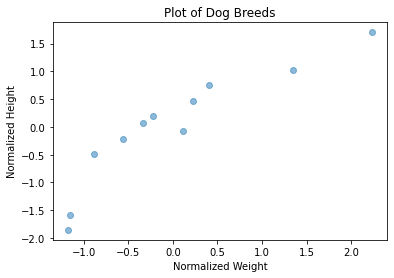

In [6]:
# Let's build a simple scatter plot
plt.scatter(dog_data_norm['weight (pounds)'], dog_data_norm['height (inches)'], alpha=0.5)
plt.title('Plot of Dog Breeds')
plt.xlabel('Normalized Weight')
plt.ylabel('Normalized Height')
plt.show()    

Gazing at the scatter plot, it looks like we could group the data into three clusters. There are the 2 data points on the bottom left (Chihuahua and Yorkshire Terrier) The top right group of two (Bull Mastiff and Great Dane) and the middle group with all the other breeds.

# **3. K-Means and the Elbow Method**
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. The objective is to group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset. 

Clusters are groups of data with similar characateristics. They are built around centroids. As with k Nearest Neighbor, you get to again set the value for k. But this time, **k defines the number of centroids**--that is, the imaginary or real location of the center in a cluster--you want to see in the dataset.

## **How does k Means Work?**
Basically, the k-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid. Here are the steps k Means takes:
1. You define k
2. The algorithm randomly places k points into the dataspace.
3. It then calculates the best position of these centroids based on which actual datapoints are the closest. This calculation is similar to the bckpropagation in a Neural Network, where the goal is to minimize the error in class assignment. The difference is that here, data points are assigned to clusters (not classes) and the calculation is not an activation function, but a Sum-of-Squares calculation. The position of the centroids adjusts until the algorithm stops.
4. The algorithm stops when either the centroids have stabilized and there is no change in their values OR when the defined number of iterations has been reached.

##**Coding k Means**

We are using the KMeans() function from [scikit-learn.cluster](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for this purpose.

The most interesting parameters are:

**n_clusters** int, default=8
The number of clusters to form as well as the number of centroids to generate.

**init: {‘k-means++’, ‘random’, ndarray, callable}, default=’k-means++’**
Method for initialization:

1. ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.

2. ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

  If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers. If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.

**n_init**: int, default=10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

**max_iter**: int, default=300
Maximum number of iterations of the k-means algorithm for a single run.

**verbose**: int, default=0
Verbosity mode. (If you like your computer to talk to you)

The following two attributes are interesting for us:
**cluster_centers_**: ndarray of shape (n_clusters, n_features)
Coordinates of cluster centers. If the algorithm stops before fully resolving, these will not be consistent with labels_.

**labels_**: ndarray of shape (n_samples,)
Labels of each point

If you want to see what kMeans used to look like when written from scratch in Python, go [here](https://benalexkeen.com/k-means-clustering-in-python/).

##**3.1 k Means and the Dog Breeds Dataset**

In [7]:
# On to clustering with kMeans. Note that the variable "labels" is an array which specifies which cluster each dog belongs to:

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, ).fit(dog_data_norm)
labels = kmeans.labels_
labels

array([1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2], dtype=int32)

My results were: array([0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2]), which indicates that the first, second, and third dogs are in cluster 0, the next one in cluster 1 and so on. That may be helpful for future tasks but is not the helpful if we are trying to visualize the data. Let's make this more "uebersichtlich" (= easy to view), though (but keep in mind that since the initial centroids are selected randomly it is possible that you get a different answer than I do):

In [8]:
groups = {0: [], 1: [], 2: []} # We have 3 clusters
i = 0                                       # Initializing the row counter
for index, row in dog_data.iterrows():      # We are now going through each row in dog_data
    groups[labels[i]].append(index)         # and appending the cluster labels/ numbers to each index
    i += 1

## Now we make a pretty list:

for key, value in groups.items():           # the key is the cluster number and the value is the names of the dogs
    print ('CLUSTER %i' % key)
    for breed in value:
        print("    %s" % breed)
    print('\n')

CLUSTER 0
    Bullmastiff
    Great Dane


CLUSTER 1
    Border Collie
    Boston Terrier
    Brittany Spaniel
    German Shepherd
    Golden Retriever
    Portuguese Water Dog
    Standard Poodle


CLUSTER 2
    Chihuahua
    Yorkshire Terrier




There you have it! That's all there is to kMeans clustering--sort of.

Let's do this with a different dataset!

##**3.2 k Means and the Iris dataset**
Wouldn't you know it, the iris dataset is so popular that it actually comes with the scikit-learn package. It is formatted as an object with an array of 4 variables with one associated target variable: the species attribute. This species attribute contains the following 3 categories:

<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/iris_types.jpg" width="500">
</div>
These categories are derived from the values in the following variables:
<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/iris_measurements.png" width="300">
</div>
Petal length, petal width and sepal length and sepal width. 
There you have it. The famous iris dataset.

We'll load it, and you get to do some basic EDA with the pandas_profiling package. This is the most famous dataset in Machine Learning. A [basic Google search](https://www.google.com/search?q=iris+dataset) turns up way too much information--don't read all of it; you'll get lost.



In [9]:
iris = datasets.load_iris() 
iris

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

We will need to stick the object into a dataframe and then extract  the features (sepal length etc.) and the corresponding class (species). The class is here called the target. For cluster analysis, we are **not** going to use the class because we want to see how the algorithm finds the natural groupings in the dataset. Later on, we can "cheat" and compare the algorithm results to what we know is the Ground Truth.

In [10]:
iris_data = pd.DataFrame(iris.data, columns=iris['feature_names'])
iris_target = pd.DataFrame(iris.target, columns=['target'])

### **3.2.1 Exploratory Data Analysis**

##Your Turn

Use the pandas_profiler package to look around the dataset!


### **3.2.2 Preprocessing**
The target/class variable is encoded as integers, but if you look at the output of our object, you see that we have target_num and target_names, so all we need to do is map one on the other, and we have the name for each target number:

In [11]:
# Map encoded target values to target names
def map_target(target_num):
    return iris.target_names[int(target_num)]

iris_target_name = iris_target.apply(map_target, 1)
iris_target_name

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Length: 150, dtype: object

### **3.2.3 Building k Means**
Now that we have loaded and processed our data, we will go ahead and fit a K-means model to the data. We will use 3 of the 4 features available (sepal length, sepal width, petal length). This will make it easier for us to visualize the results of the model in 3D.

Because we know that the class attribute has three levels (virginica, setosa, versicolor), we decide to set k=3.

In [12]:
# Build kmeans

# kmeans_3 = KMeans(n_clusters=3, verbose = 1) # uncomment if you want to see how it cycles through the centroid assignment
kmeans_3 = KMeans(n_clusters=3)

In [13]:
# Fit a K-Means model to the data

kmeans_iris = kmeans_3.fit(iris_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']])

Let's visualize our K-Means model's results (visualization code adapted from an example in scikit-learn documentation).

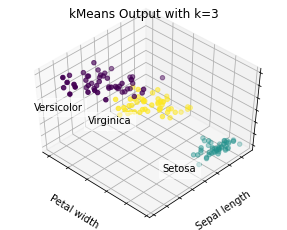

In [14]:
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

X=iris.data
y=kmeans_iris.labels_ # These are the cluster labels that kMeans has assigned

for name, label in [('Setosa', 0),
                    ('Versicolor', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results

y = np.choose(iris_target.target, [1, 2, 0]).astype(float)

ax.scatter(iris_data.iloc[:, 3], iris_data.iloc[:, 0], iris_data.iloc[:, 2], c=y.astype(float))
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('kMeans Output with k=3')
plt.show()

### **3.2.4 Quality Check!**
**Let's cheat!**

We already know that we should have discovered three clusters because the original dataset contains three types of irises in the species class. So, let's compare the clusters that we have discovered with the actual labels in the species attribute.

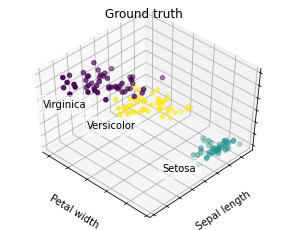

In [15]:
# Plot the ground truth

X = iris.data
y = iris.target
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolor', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(iris_target.target, [1, 2, 0]).astype(float)
ax.scatter(iris_data.iloc[:, 3], iris_data.iloc[:, 0], iris_data.iloc[:, 2], c=y)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground truth')
plt.show()

### **3.2.5 The BIG Question**
The next question is: How big should k be? Let's experiment!

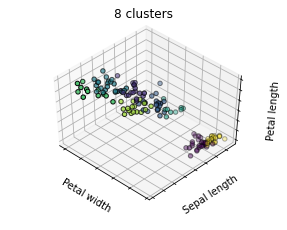

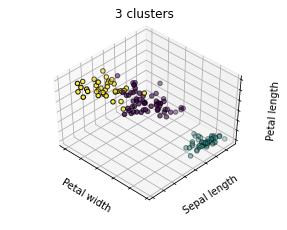

In [16]:
# Now we plot the output of our kMeans analysis, for k=3 and k=8

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3))]

fignum = 1
titles = ['8 clusters', '3 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

8 clusters does not show any improvement. So, we're back to our initial 3. Let's see how well the clusters are defined:

In [17]:
print(pd.Series([(iris_target_name.loc[i][0], kmeans_iris.labels_[i]) for i in range(len(iris.target))]).value_counts())

(v, 2)    58
(s, 0)    50
(v, 1)    42
dtype: int64


As the above visualizations and statistics show, our simple model with k=3 has done a decent task of classifying the datapoints into separate clusters. You can see that the two plots resemble each other. When compared with actual classes, the model clustered together some datapoints belonging to different classes. Although the predictions aren’t perfect, they come close. That’s a win for the algorithm.

## **3.3 Elbow method for finding optimal number of clusters**
In unsupervised learning, you rarely get an output that’s 100 percent accurate because real-world data is just not that simple.
Apart from simplicity of the dataset, the reason why the above model performed so well was because we knew beforehand the optimal numbers of clusters, i.e. 3. Out in the wild, you won’t know how many clusters to choose (or any initialization parameter for other clustering algorithms). Such parameter-tuning is critical.

One of the methods for determining the optimal number of clusters for the K-Means algorithm is the elbow method.

The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE). Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.

The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

**Be sure to execute the code below to see how the elbow builds!**

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


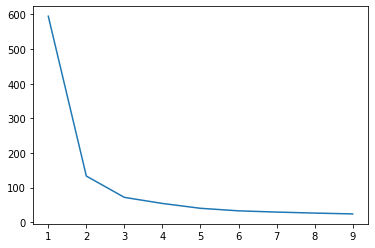

In [18]:
# Elbow method

def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

elbow_plot(iris_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']], maxK=10)

As we can see from the above plot, 2 or 3 look like a good choice for number of clusters--2 because that's where the really obvious break occurs, and 3 because the slope of the curve becomes pretty linear after 3.

Wait ... 2? Or 3?

If you scroll up to the graphics, you'll be able to tell why: Look how the virginica and the versicolor "clusters" are intertwined! We can only separate them if we really know they are there, but they are still discoverable. That's why the elbow curve changes direction at 2 clusters, and becomes linear after 3. The trick is to ***look for*** the greatest difference in slope but ***pick*** the point **AFTER** which the slope decreases in a linear fashion. So, the correct answer is 3.

As you can see, the elbow criterion doesn't always give you very clear answers. In cases like this, we might try a different method for determining the optimal k, such as [computing silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), or we might even reevaluate whether clustering is the right thing to do on our data.

## Your Turn
**Exercise 1: kMeans for the dog_data**


Make an elbow plot for the dog data above and then re-run the kMeans analysis with the optimal k. Plot the results.

In [19]:
# Start with the elbow plot in this cell

In [20]:
# Now run k Means with the optimal k you have just determined.

# **4. Hierarchical Clustering**
For the next approach we don’t specify how many clusters to make. Instead the algorithm starts with each instance in its own cluster. At each iteration of the algorithm it combines the two most similar clusters into one. It repeatedly does this until there is only one cluster. This is called hierarchical clustering and its name makes sense. The running of the algorithm
results in one cluster, which consists of two sub-clusters. Each of those two sub-clusters in turn, consist of 2 sub-sub clusters and so on.

We have 3 types of clusters:
1. **Single-Link**: In single-linkage clustering we define the distance between two clusters as the shortest
distance between any member of one cluster to any member of the other. 
2. **Complete-Link**: In complete-linkage clustering we define the distance between two clusters as the greatest
distance between any member of one cluster to any member of the other. 
3. **Average-Link**: In average-linkage clustering we define the distance between two clusters as the average
distance between any member of one cluster to any member of the other. 

<img src = 'https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/The-three-linkage-types-of-hierarchical-clustering-single-link-complete-link-and.png'>

For this purpose, we use the Euclidian distance again.


Read more about clustering [here](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering).

In [21]:
from sklearn.cluster import AgglomerativeClustering

dog_data = pd.read_csv('https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/dogs.csv')
dog_data = dog_data.set_index('breed')
dog_data

,height (inches),weight (pounds)
breed,,
Border Collie,20,45
Boston Terrier,16,20
Brittany Spaniel,18,35
Bullmastiff,27,120
Chihuahua,8,8
German Shepherd,25,78
Golden Retriever,23,70
Great Dane,32,160
Portuguese Water Dog,21,50


## **4.1 Agglomerative Clustering**
We are using the AgglomerativeClustering() function [link text](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) from scikit-learn.cluster.

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria (see above) determines the metric used for the merge strategy.

In [22]:
clusterer = AgglomerativeClustering(affinity='euclidean', linkage='ward')
clusterer.fit(dog_data_norm)

AgglomerativeClustering()

In [23]:
clusterer.labels_

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

So here the first dog breed, Border Collie, belongs to cluster 0. Keep in mind that in kMeans there is a random element--the selection of the initial centroids, but **in hierarchical clustering there is no randomness** so you should get the exact same answer I have here. 

## **4.2 Hierarchical Clustering and Dendrograms**
Remember that the hierarchical clustering algorithm constructs a tree - specifically, a dendrogram. To view that requires some imagination. You can print dendrograms in different ways. A very plain and ugly way is here:

In [24]:
import itertools
ii = itertools.count(dog_data_norm.shape[0])
[{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in clusterer.children_]

[{'left': 0, 'node_id': 11, 'right': 8},
 {'left': 4, 'node_id': 12, 'right': 10},
 {'left': 5, 'node_id': 13, 'right': 6},
 {'left': 1, 'node_id': 14, 'right': 2},
 {'left': 9, 'node_id': 15, 'right': 11},
 {'left': 14, 'node_id': 16, 'right': 15},
 {'left': 3, 'node_id': 17, 'right': 7},
 {'left': 13, 'node_id': 18, 'right': 16},
 {'left': 12, 'node_id': 19, 'right': 18},
 {'left': 17, 'node_id': 20, 'right': 19}]

The first line {'left': 0, 'node_id': 11, 'right': 8} reads like this: "We combine cluster 0 Border Collie with cluster 8 Portuguese Water Dog to create Cluster 11." The next line says we combine 4 Chihuahua with 10 Yorkshire Terrier to create cluster 12. Let's associate index numbers with the dog breed names so that structure is easier to read:

In [25]:
dog_names = pd.DataFrame({'breeds': dog_data_norm.index.values})
dog_names

,breeds
0,Border Collie
1,Boston Terrier
2,Brittany Spaniel
3,Bullmastiff
4,Chihuahua
5,German Shepherd
6,Golden Retriever
7,Great Dane
8,Portuguese Water Dog
9,Standard Poodle


That makes it easier to interpret lines like:

{'left': 1, 'node_id': 14, 'right': 2},
We are combining 1 Boston Terrier and 2 Brittany Spaniel.![dendro[1].png]('sxkaXYgY2xhc3M9IkJ0bkdyb3VwIG10LTEgbXQtbWQtMCBtbC0yIj4KICAgICAgICAgICAgICAgIDxidXR0b24gY2xhc3M9ImJ0biBidG4tb3V0bGluZSBCdG5Hcm91cC1pdGVtIGpzLWFjY2VwdC1hbmFseXRpY3MtY29va2llcyIgdHlwZT0iYnV0dG9uIj5BY2NlcHQ8L2J1dHRvbj4KICAgICAgICAgICAgICAgIDxidXR0b24gY2xhc3M9ImJ0biBidG4tb3V0bGluZSBCdG5Hcm91cC1pdGVtIGpzLXJlamVjdC1hbmFseXRpY3MtY29va2llcyIgdHlwZT0iYnV0dG9uIj5SZWplY3Q8L2J1dHRvbj4KICAgICAgICAgICAgICA8L2Rpdj4KICAgICAgICAgICAgPC9kaXY+CiAgICAgICAgICA8L2Rpdj4KCiAgICAgICAgICA8ZGl2IGNsYXNzPSJ0ZXh0LXJpZ2h0IHB5LTMgYm9yZGVyLXRvcCI+CiAgICAgICAgICAgIDxidXR0b24gY2xhc3M9ImJ0biBidG4tcHJpbWFyeSBqcy1zYXZlLWNvb2tpZS1wcmVmZXJlbmNlcyIgdHlwZT0iYnV0dG9uIiBkaXNhYmxlZD5TYXZlIHByZWZlcmVuY2VzPC9idXR0b24+CiAgICAgICAgICA8L2Rpdj4KICAgICAgICA8L2Rpdj4KPC9kaXY+PC9kaXY+ICA8L2Rpdj4KPC9kaXY+CgoKICA8L2JvZHk+CjwvaHRtbD4KCg==)

That's what we get when we draw this.



That still isn't really pretty. Let's plot this as a dendrogram (with plotly's figure factory)!

In [26]:
import plotly.figure_factory as ff
fig = ff.create_dendrogram(dog_data, labels=dog_data.index)
fig.update_layout(width=800, height=500)
fig.show()

We can also plot with pandas, which saves us one line of code:

In [27]:
from plotly.figure_factory import create_dendrogram
fig = create_dendrogram(dog_data, labels=dog_data.index)
fig.show()

## Your Turn
**Exercise 2: Run a hierarchical analysis for the Iris dataset**

You've seen the analysis for the dogs above. Now run the same thing for the iris dataset.

# **5. Density-Based Clustering (DBSCAN)**
Dansity-Based clustering finds core samples of high density and expands clusters from them. In other words, it views clusters as areas of high density separated by areas of low density. Good for data which contains clusters of similar density.Here, we are working with neighbors within a radius!

We are using the [DBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) from the scikit-learn.cluster family. Because DBSCAN really requires visualizzation, we'll start with a dataset that allows us to visualize the output the best: The [make_moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). 

Read more about how DBSCAN works [here](https://scikit-learn.org/stable/modules/clustering.html#dbscan).

In [28]:
## import data
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris # reloading iris cleanly
from sklearn import datasets

## import DBSCAN model
from sklearn.cluster import DBSCAN
from sklearn import metrics

plt.style.use('ggplot')
%matplotlib inline

##**5.1 Example 1: make_moons dataset**
This is just a small dataset that help visualize density-based clustering. It has no meaning other than the shape you see.

In [29]:
# import the data from sklearn.datasets.make_moons
X_1, labels_true = make_moons(n_samples=200, noise=0.1, random_state=19)
print(X_1[:10,])

[[ 0.28171457  0.91044406]
 [ 0.8389241  -0.53005338]
 [ 0.40915474  0.80944352]
 [-0.98415213  0.13142155]
 [ 1.15919021  0.4910425 ]
 [-0.96703486  0.0981273 ]
 [ 0.91739138 -0.2334927 ]
 [ 0.97827508  0.50147001]
 [ 1.85907097  0.33087146]
 [ 1.28971276 -0.36416076]]


##**5.1.1 Setting up our DBSCAN model**

Note that the DBSCAN model requires two parameters, eps and min_samples.

* eps is a radius which defines neighborhood for a data point.
* min_samples (or minPts) is the minimum number of points required to form a dense region within a radius eps.

In [30]:
model_1 = DBSCAN(eps=0.25, min_samples=12).fit(X_1)
print(model_1) # model set-ups and parameters

DBSCAN(eps=0.25, min_samples=12)


In [31]:
## Another way to see parameters and definition of the DBSCAN model
model_1.get_params

<bound method BaseEstimator.get_params of DBSCAN(eps=0.25, min_samples=12)>

##**5.1.2 Reviewing the labels**
We can now take a look at the cluster labels that our model_1 has assigned.

In [32]:
labels_1=model_1.labels_
labels_1

array([ 0,  1,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0,  1,  0,  1,  0,
        1,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,
        0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  1, -1,  1,  0,  1,  1,  1,  0,  1,  0,  0,  1,
        1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1,  1,
        0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,
        0,  1,  0,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,  0,  0,
        0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
        1,  1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0])

In [33]:
# Alternative way to access the cluster labels (the same as above) 
model_1.fit_predict(X_1)

array([ 0,  1,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0,  1,  0,  1,  0,
        1,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,
        0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  1, -1,  1,  0,  1,  1,  1,  0,  1,  0,  0,  1,
        1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1,  1,
        0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,
        0,  1,  0,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,  0,  0,
        0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
        1,  1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0])

## **5.1.3 Plotting the clusters**
Visualization is really important with these kinds of clusters. 

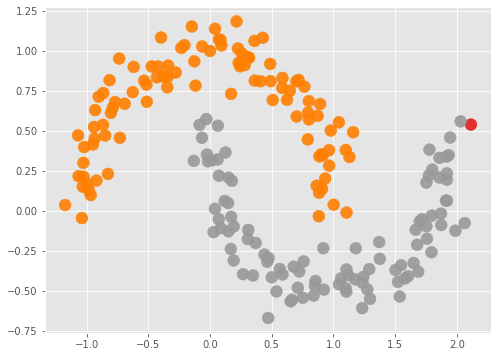

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_1[:, 0], X_1[:, 1], c=model_1.labels_, s=140, alpha=0.9, cmap=plt.cm.Set1)

fig.show()

We can also get the answer about the detected clusters like this:

In [35]:
# Number of clusters in labels, ignoring noise points
n_clusters_ = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


If there is noise in this dataset, we can also identify the noise points:

In [36]:
print("Number of Noise Points: ",sum(model_1.labels_==-1)," (",len(model_1.labels_),")",sep='')

Number of Noise Points: 1 (200)


## **5.2 DBSCAN and the iris dataset**
Here is an analysis of the iris dataset again.

In [37]:
# Import the Iris dataset from scikit-learn
iris = datasets.load_iris()
X = iris.data    
y = iris.target
target_names = iris.target_names

Let's convert it to a dataframe again.

In [38]:
df = pd.DataFrame(X, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's see what a basic scatterplot shows us.

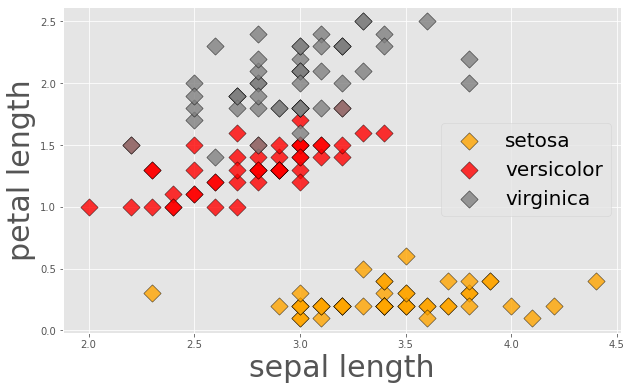

In [39]:
## Show only two features 'Sepal length' and 'petal length' for different types of flowers (target labels)
plt.figure(2, figsize=(10, 6))
colors = ['orange', 'red', 'gray']


for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X[y == i, 1], X[y == i, 3], color=color, alpha=.8, 
                label=target_name, s=150, cmap=plt.cm.Set1, edgecolor='k',marker='D')
plt.legend(loc='best', shadow=False, scatterpoints=1,fontsize=20)
plt.xlabel('sepal length', fontsize=30) 
plt.ylabel('petal length', fontsize=30) 
plt.show()

## **5.2.1 Setting up the model**

In [40]:
model = DBSCAN(eps=0.8, min_samples=6).fit(X)
labels=model.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Getting the number of clusters.

In [41]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

2

## **5.2.2 Plotting the clusters**

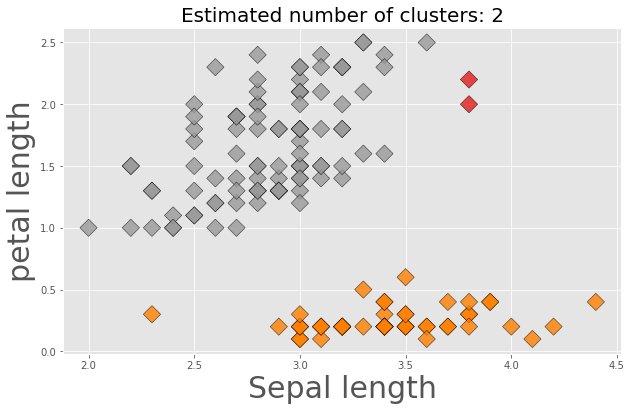

In [42]:
plt.figure(2, figsize=(10, 6))
plt.scatter(X[:, 1], X[:, 3], c=model.labels_, s=150,  cmap=plt.cm.Set1,alpha=.8, edgecolor='k',marker='D')
#plt.scatter(X[:, 1], X[:, 3], c=y, s=150, cmap=plt.cm.Set1, edgecolor='k', marker='D')   #target 
plt.xlabel('Sepal length', fontsize=30) 
plt.ylabel('petal length', fontsize=30) 
plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=20)
plt.show()

## **5.2.3 Evaluating the model: Completeness & homogeneity scores**

These scores tell you how well the clustering algorithm performed.
* Perfect homogeneity score=1, perfect completeness score =1: your clustering matches your classes perfectly.

* A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

* A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [43]:
# Examples for perfect scores
# Perfect labelings are complete and homogeneous:
print("Completeness: %0.1f" %  metrics.completeness_score([0, 0, 1, 1], [1, 1, 0, 0]))

Completeness: 1.0


In [44]:
# completeness: for a given class, are all its points placed in one cluster?
print("Completeness: %0.1f" %  metrics.completeness_score([0, 0, 1, 1], [0, 0, 0, 0]))

Completeness: 1.0


In [45]:
# Homogeneity: for a given cluster, do all the points in it come from the same class?
print("Homogeneity: %0.1f" %  metrics.homogeneity_score([0, 0, 1, 1], [0, 0, 0, 0]))

Homogeneity: 0.0


And now back to our iris dataset!

In [46]:
model_2 = DBSCAN(eps=0.8, min_samples=6).fit(X)
labels=model_2.labels_
labels_true = iris.target

print("Completeness: %0.2f" % metrics.completeness_score(labels_true, labels))
print("Homogeneity: %0.2f" % metrics.homogeneity_score(labels_true, labels))

Completeness: 0.92
Homogeneity: 0.59


##Your Turn 
**Exercise 3: DBSCAN and Dog Breeds**

Apply DBSCAN to the dog breeds dataset using the code fields below. Create a visualization. 

In [47]:
# Build your DBSCAN algorithm here

In [48]:
# Create your visualization here

In the field below, describe how the output from this algorithm differs from what you have seen with k Means and Hierarchical Clustering. 



Which of the three clustering approaches is best for the dog breeds dataset? Which one works best for the iris dataset? Answer these two questions in the field below.

#**Congratulations! You're done with this module!**

<div>
<center>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/dog_smile.jpg" width="500">
</div>